# Baseline Retrieval

Armanni Luca - 509085

Ghiotto Alessandro - 513944

---

In this notebook we see the performances of a baseline retrieval model with different text preprocessing.

### Table of contents:
- Configuration and Model choice
  - Create the indexes
  - Run the models
- Tuning BM25

In [1]:
# !pip install --upgrade -q python-terrier
# !pip install emoji
# !gdown 1HhgXzyEpsZNcenU9XhJuOYyDUKEzUse4
# !unzip pir_data.zip

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import os
import shutil

# Move to the parent directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    
# TEXT PROCESSING
from textblob import TextBlob
import emoji
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# TERRIER
from pyterrier.measures import *
import pyterrier as pt

if not pt.java.started():
    pt.utils.set_tqdm('notebook')
    pt.java.init()


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [2]:
##### UTILITY function
### DISPLAY STYLED df
# set with colors highest values in each column
def display_styled(df, ignore_cols=[], color="#37614a"):
    """ignore_cols: list of columns to not color"""
    def highlight_max(s):
        if s.name in ignore_cols:  # Skip styling for the 'Name' column
            return ['' for _ in s]
        is_max = s == s.max()
        return [f'font-weight: bold; background-color: {color};' if v else '' for v in is_max]

    styled_df = (
        df.style
        .apply(highlight_max, axis=0)  # Apply styling
        .format({col: "{:.3f}" for col in df.select_dtypes(include='number').columns})  # Format numeric columns only
    )
    display(styled_df)
    return None

Our base (applied in all the configurations) preprocessing consists of:
- remove emojis
- remove links
- text normalization (lowercase)
- remove special characters
- remove whitespaces

In [3]:
def text_preprocessing(text):
    # remove emojis
    text = emoji.replace_emoji(text, "")
    # remove links
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    # remove html tags
    # text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # lowercase verything
    text = text.lower()
    # remove backslashes
    text = re.sub(r"\\", "", text)
    # remove special characters and punctuation
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # remove whitespaces
    text = re.sub(r"\s+", " ", text)
    # remove leading and trailing whites
    text = text.strip()
    # apply spelling correction
    # text = TextBlob(text).correct()
    return text

In [4]:
# COLLECTION OF DOCUMENTS (ANSWERS)
def preprocess_corpus(df):
    df = df.reset_index()
    df.columns = ['docno', 'text']
    df['text'] = df['text'].apply(text_preprocessing)
    df = df.reset_index(drop=True)
    return df

corpus_df = preprocess_corpus(pd.read_json('PIR_data/answer_retrieval/subset_answers.json', orient='index'))

# SAMPLES (QUERIES)
def preprocess_queries_df(path):
    df = pd.read_json(path, lines=True)
    df = df[['id','title', 'text']]
    df.columns = ['qid', 'query_title', 'query_text']
    df['query_text'] = df['query_text'].apply(text_preprocessing)
    df['query_title'] = df['query_title'].apply(text_preprocessing)
    df = df.reset_index(drop=True)
    return df

train_queries = preprocess_queries_df('PIR_data/answer_retrieval/train/subset_data.jsonl')
val_queries = preprocess_queries_df('PIR_data/answer_retrieval/val/subset_data.jsonl')
# test_queries = preprocess_queries_df('PIR_data/answer_retrieval/test/subset_data.jsonl')

# QRELS
def preprocess_qrels_df(path):
    df = pd.read_json(path, orient='index').reset_index()
    df.columns = ['qid', 'docno']
    df['label'] = 1
    df = df.reset_index(drop=True)
    return df

train_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/train/qrels.json')
val_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/val/qrels.json')
# test_qrels = preprocess_qrels_df('PIR_data/answer_retrieval/test/qrels.json')

print("ANSWERS")
display(corpus_df.head(3))
print("QUERIES")
display(train_queries.head(3))
print("QRELS")
display(train_qrels.head(3)) 

ANSWERS


,docno,text
0,writers_2010,tldrif youre going to do present tense do it f...
1,writers_2018,your writing style is streamofconsciousness wh...
2,writers_2023,place emphasis on uncomfortable things dependi...


QUERIES


,qid,query_title,query_text
0,academia_100305,what are cnrs research units and how are they ...,what are cnrs research units and how are they ...
1,academia_100456,is there a free as in freedom alternative to p...,is there a free as in freedom alternative to p...
2,academia_103390,search for stackexchange citations with google...,search for stackexchange citations with google...


QRELS


,qid,docno,label
0,academia_100305,academia_100217,1
1,academia_100456,academia_100462,1
2,academia_103390,academia_103391,1


# Configuration and Model choice

We will do a grid seach on the following options:
- **remove stopwords** or not remove them
- **stem** (Porter) the words or not stem them
- use the **'text'** or just the **'title'** for the questions
- use **BM-25** or **TF-IDF** model

Measures of interest: [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']
- **P@1** and P@3 are the most important for a question answering SE, we want the correct answer at the top,
- nDCG@3, nDCG@10 and MAP@100 for having a general look at how the ranking goes,
- R@100 looking at an high value for the recall is useful for choosing a first stage retriever, for applying reranking later
- Mean response time (mrt) will report the average number of milliseconds to conduct a query

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# define preprocessing function for documents
def all_preprocessing_options(text, apply_stemmer=False, remove_stopwords=False):
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    if apply_stemmer:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# precompute all possible combinations of preprocessing options
corpus_df['text_plain'] = corpus_df['text']
corpus_df['text_stemmed'] = corpus_df['text'].apply(lambda x: all_preprocessing_options(x, apply_stemmer=True))
corpus_df['text_stopwords_removed'] = corpus_df['text'].apply(lambda x: all_preprocessing_options(x, remove_stopwords=True))
corpus_df['text_stemmed_stopwords_removed'] = corpus_df['text'].apply(lambda x: all_preprocessing_options(x, apply_stemmer=True, remove_stopwords=True))

[nltk_data] Downloading package stopwords to /home/ghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average length of text before removing stopwords: 1321.84
Average length of text after removing stopwords: 910.82


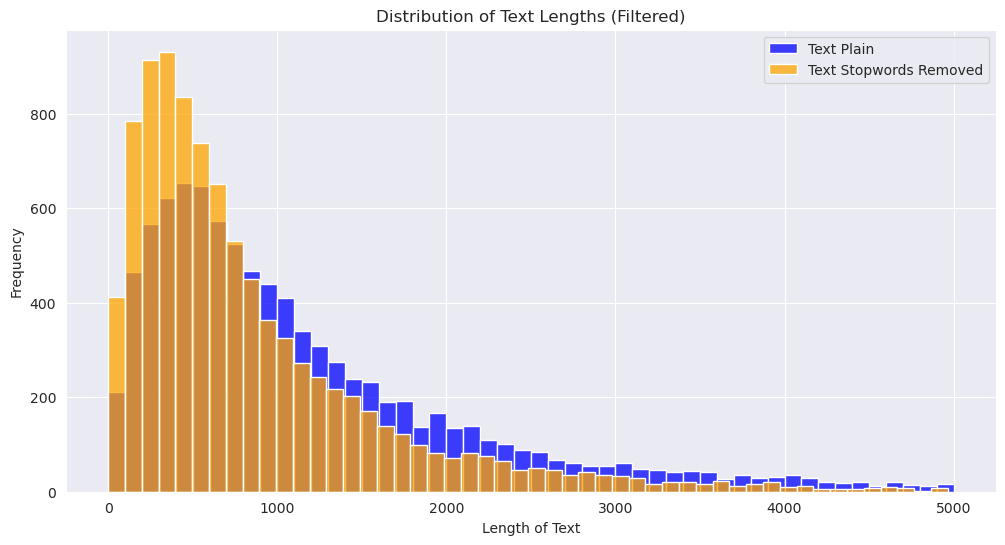

In [6]:
# compare the length of the text before and after removing stopwords
length_text_plain = corpus_df['text_plain'].apply(len)
length_text_stopwords_removed = corpus_df['text_stopwords_removed'].apply(len)

# Set a threshold for visualization
threshold = 5000
filtered_length_text_plain = length_text_plain[length_text_plain <= threshold]
filtered_length_text_stopwords_removed = length_text_stopwords_removed[length_text_stopwords_removed <= threshold]

print("Average length of text before removing stopwords:", length_text_plain.mean().round(2))
print("Average length of text after removing stopwords:", length_text_stopwords_removed.mean().round(2))

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(filtered_length_text_plain, label='Text Plain', color='blue', bins=50)
sns.histplot(filtered_length_text_stopwords_removed, label='Text Stopwords Removed', color='orange', bins=50)
plt.title('Distribution of Text Lengths (Filtered)')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# stemming vs no stemming
# Calculate the size of the vocabulary for each configuration
vocab_plain = set(" ".join(corpus_df['text_plain']).split())
vocab_stemmed = set(" ".join(corpus_df['text_stemmed']).split())

print("Vocabulary size without stemming:", len(vocab_plain))
print("Vocabulary size with stemming:", len(vocab_stemmed))

Vocabulary size without stemming: 125028
Vocabulary size with stemming: 103108


- removing stopwords: allow us to occupy less memory
- stemming: allow us to get a smaller vocabulary, this could help us to match more words

In [8]:
# searh for nulls or zero length
null_values = corpus_df[['text_plain', 'text_stopwords_removed']].isnull().sum()
zero_length_values = corpus_df[['text_plain', 'text_stopwords_removed']].map(lambda x: len(x) == 0).sum()
null_or_zero_length = null_values + zero_length_values
null_or_zero_length = null_or_zero_length[null_or_zero_length > 0]

print("number of null or zero-length values in the following columns:")
display(null_or_zero_length)

# display how this entries looked like, before the preprocessing
null_etries = corpus_df[corpus_df['text_plain'].isnull() | corpus_df['text_plain'].map(lambda x: len(x) == 0)]

og_corpus_df = pd.read_json('PIR_data/answer_retrieval/subset_answers.json', orient='index')
og_corpus_df = og_corpus_df.reset_index()
og_corpus_df.columns = ['docno', 'text']
og_null_entries = og_corpus_df[og_corpus_df['docno'].isin(null_etries['docno'])]
print("original entries, that gets empty after the preprocessing:")
display(og_null_entries)

# DROP THEM
corpus_df = corpus_df[~corpus_df['text_plain'].isnull() & corpus_df['text_plain'].map(lambda x: len(x) > 0)]

number of null or zero-length values in the following columns:


text_plain                3
text_stopwords_removed    3
dtype: int64

original entries, that gets empty after the preprocessing:


,docno,text
4330,judaism_2117,"הַאֲזִינוּ פרק לב פסוק והַ לְיְהוָה, תִּגְמְלו..."
4454,judaism_6505,http://www.softmatza.com/
4708,judaism_44648,מסכתות קטנות מסכת אבות דרבי נתן נוסחא א פרק מא...


We can see that the values that now are empties are given by docs completely not in english, or one constituted by just a link. Since we have seen that the majority of data is in english, we will just ignore them.

### Create the Indexes

Next we are going to create the indexes, one for each configuration.

In [9]:
root = "./index_sepqa/"
os.makedirs(root, exist_ok=True)

# index documents for all configurations
index_paths = {
    "plain": os.path.join(root, "index_plain"),
    "stemmed": os.path.join(root, "index_stemmed"),
    "stopwords_removed": os.path.join(root, "index_stopwords_removed"),
    "stemmed_stopwords_removed": os.path.join(root, "index_stemmed_stopwords_removed"),
}

In [10]:
max_docno = corpus_df['docno'].apply(len).max()

# we create a separate index for each configuration
for config, path in index_paths.items():
    os.makedirs(path, exist_ok=True)
    
    # If the index already exists, delete it
    if os.path.exists(path):
        shutil.rmtree(path)

    max_text = corpus_df[f"text_{config}"].apply(len).max()

    # stemmer and stopwords are set to None since we have handled them in the preprocessing
    indexer = pt.IterDictIndexer(path, stemmer=None, stopwords=None)
    indexer.index(
        corpus_df.to_dict(orient='records'),
        fields={f"text_{config}": max_text}, 
        meta={'docno': max_docno},
    )

print("Indexes created in the ./index_sepqa folder:")
!ls ./index_sepqa/

Indexes created in the ./index_sepqa folder:
index_bm25			 subset_answers_with_users.json
index_bm25_users		 tags_vocabulary_full.joblib
index_plain			 user_community_full.joblib
index_stemmed			 user_tags_full.joblib
index_stemmed_stopwords_removed  user_tags_full_list.joblib
index_stopwords_removed		 user_tags_subset.joblib
MiniLM_faiss_IndexFlatIP.index


We preprocesses also the queries in all the combinations that we have done for the indexing. We just take a subset of the data so the experiments don't requires too much time.

In [ ]:
# precompute all possible combinations of preprocessing options
# so we get all possible configurations for the queries

def get_all_queries(queries_df, use_full_text=False):
    queries = queries_df.copy()
    if use_full_text:
        queries['query'] = queries['query_text']
    else:
        queries['query'] = queries['query_title']
    queries = queries[['qid', 'query']]

    preprocessed_queries = queries.copy()
    preprocessed_queries['plain'] = queries['query'].apply(lambda x: all_preprocessing_options(x))
    preprocessed_queries['stemmed'] = queries['query'].apply(lambda x: all_preprocessing_options(x, apply_stemmer=True))
    preprocessed_queries['stopwords_removed'] = queries['query'].apply(lambda x: all_preprocessing_options(x, remove_stopwords=True))
    preprocessed_queries['stemmed_stopwords_removed'] = queries['query'].apply(lambda x: all_preprocessing_options(x, apply_stemmer=True, remove_stopwords=True))
    preprocessed_queries = preprocessed_queries[['qid', 'plain', 'stemmed', 'stopwords_removed', 'stemmed_stopwords_removed']]
    return preprocessed_queries


# get a subset of train data 
size = 1000
train_sub = train_queries.sample(size, random_state=42)
train_sub_qrels = train_qrels[train_qrels['qid'].isin(train_sub['qid'])]

train_sub_title = get_all_queries(train_sub)
train_sub_text = get_all_queries(train_sub, use_full_text=True)
train_sub_configs = {'text':train_sub_text, 'title':train_sub_title}
print("TEXT:\n", train_sub_configs['text'].iloc[1], sep="")
print("\nTITLE:\n", train_sub_configs['title'].iloc[1], sep="")

TEXT:
qid                                                                 pets_17584
plain                        how to kill ticks on a rabbit having just lear...
stemmed                      how to kill tick on a rabbit have just learn t...
stopwords_removed            kill ticks rabbit learned rabbits flea treatme...
stemmed_stopwords_removed    kill tick rabbit learn rabbit flea treatment e...
Name: 4684, dtype: object

TITLE:
qid                                             pets_17584
plain                        how to kill ticks on a rabbit
stemmed                       how to kill tick on a rabbit
stopwords_removed                        kill ticks rabbit
stemmed_stopwords_removed                 kill tick rabbit
Name: 4684, dtype: object


### Run the models

create the indexes, the retrievers model and the metrics. then run the Experiment

In [ ]:
# load the indexes
indexes = {config: pt.IndexFactory.of(os.path.join(path, "data.properties")) for config, path in index_paths.items()}

# define the retrievers with different configurations
# properties={"termpipelines": ""} for disabling the default term pipelines, which is "termpipelines" : "Stopwords,PorterStemmer"
# we handle the stopwords and stemming in the preprocessing
retrievers = {
    "BM25": {config: pt.terrier.Retriever(index, wmodel="BM25", properties={"termpipelines": ""}) for config, index in indexes.items()},
    "TF_IDF": {config: pt.terrier.Retriever(index, wmodel="TF_IDF", properties={"termpipelines": ""}) for config, index in indexes.items()}
}

# define the evaluation metrics
eval_metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']

# root dir for saving the runs
root_runs = "./experiments/baseline/"
if not os.path.exists(root_runs):
    os.makedirs(root_runs, exist_ok=True)

results = []

# run the experiments for all configurations
for text_or_title in ['text', 'title']:
    for model in ['BM25', 'TF_IDF']:
        for config in ['plain', 'stemmed', 'stopwords_removed', 'stemmed_stopwords_removed']:
            print(f"Running {text_or_title}_{model}_{config}")
            # take the corresponding retriever model
            retriever_model = retrievers[model][config]
            # take the corresponding queries for this configuration
            corresponding_queries = train_sub_configs[text_or_title][['qid', config]]
            corresponding_queries.columns = ['qid', 'query']
            # run the experiment
            res = pt.Experiment(
                [retriever_model],
                corresponding_queries,
                train_sub_qrels,
                eval_metrics=eval_metrics,
                names=[f"{text_or_title}_{model}_{config}"],
                save_dir=root_runs,
                save_mode='overwrite' # 'reuse', default='warn'
            )
            results.append(res)

Running text_BM25_plain
Running text_BM25_stemmed
Running text_BM25_stopwords_removed
Running text_BM25_stemmed_stopwords_removed
Running text_TF_IDF_plain
Running text_TF_IDF_stemmed
Running text_TF_IDF_stopwords_removed
Running text_TF_IDF_stemmed_stopwords_removed
Running title_BM25_plain
Running title_BM25_stemmed
Running title_BM25_stopwords_removed
Running title_BM25_stemmed_stopwords_removed
Running title_TF_IDF_plain
Running title_TF_IDF_stemmed
Running title_TF_IDF_stopwords_removed
Running title_TF_IDF_stemmed_stopwords_removed


In [ ]:
results_df = pd.concat(results)

# save into csv file
path = "./experiments/baseline/results_baseline.csv"
results_df.to_csv(path, index=True)

results_df = results_df.set_index('name')
display_styled(results_df, ignore_cols=['mrt'])

,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
name,,,,,,,
text_BM25_plain,0.453,0.176,0.498,0.521,0.710,0.503,37.988
text_BM25_stemmed,0.485,0.190,0.535,0.561,0.758,0.539,38.099
text_BM25_stopwords_removed,0.666,0.254,0.723,0.749,0.917,0.726,13.838
text_BM25_stemmed_stopwords_removed,0.689,0.265,0.751,0.772,0.923,0.749,13.579
text_TF_IDF_plain,0.609,0.232,0.661,0.686,0.838,0.664,21.960
text_TF_IDF_stemmed,0.615,0.241,0.678,0.700,0.863,0.677,23.737
text_TF_IDF_stopwords_removed,0.661,0.253,0.720,0.745,0.915,0.722,14.452
text_TF_IDF_stemmed_stopwords_removed,0.687,0.263,0.747,0.770,0.917,0.747,13.889
title_BM25_plain,0.441,0.184,0.506,0.540,0.757,0.512,13.790


In [14]:
# Calculate the difference between text and title results
text_results = results_df.filter(like='text', axis=0)
title_results = results_df.filter(like='title', axis=0)
text_results = text_results.sort_index()
title_results = title_results.sort_index()

# Calculate the difference
difference = text_results.values - title_results.values
text_results.index = text_results.index.str.replace('text_', 'diff_')
difference_df = pd.DataFrame(difference, index=text_results.index, columns=text_results.columns)

# Display the differences
print("Difference between text and title queries:")
display(difference_df.round(3))

Difference between text and title queries:


,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
name,,,,,,,
diff_BM25_plain,0.012,-0.008,-0.008,-0.019,-0.047,-0.009,9.515
diff_BM25_stemmed,-0.002,-0.011,-0.018,-0.026,-0.035,-0.018,10.380
diff_BM25_stemmed_stopwords_removed,0.129,0.040,0.125,0.119,0.080,0.123,4.497
diff_BM25_stopwords_removed,0.154,0.042,0.140,0.137,0.092,0.143,5.604
diff_TF_IDF_plain,0.097,0.025,0.085,0.082,0.036,0.087,9.717
diff_TF_IDF_stemmed,0.060,0.019,0.058,0.051,0.047,0.056,9.716
diff_TF_IDF_stemmed_stopwords_removed,0.128,0.038,0.121,0.117,0.075,0.120,3.845
diff_TF_IDF_stopwords_removed,0.148,0.043,0.138,0.133,0.092,0.139,5.218


From the difference between using the text and using just the title, we can see that using the full text gives alwasy better performances except if we use BM25 without removing the stopwords.

In [15]:
# Calculate the difference between tf-idf and bm-25 results, only for the text
tfidf_results = results_df.filter(like='TF_IDF', axis=0)
bm25_results = results_df.filter(like='BM25', axis=0)

# Ensure both dataframes have the same index order
tfidf_results = tfidf_results.sort_index()
bm25_results = bm25_results.sort_index()

difference = bm25_results.values - tfidf_results.values
bm25_results.index = bm25_results.index.str.replace('BM25', 'diff')
difference_df = pd.DataFrame(difference, index=bm25_results.index, columns=bm25_results.columns)

# Display the differences
print("Difference between BM25 and TF-IDF:")
display(difference_df.round(3))

Difference between BM25 and TF-IDF:


,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
name,,,,,,,
text_diff_plain,-0.155,-0.057,-0.163,-0.165,-0.127,-0.162,0.457
text_diff_stemmed,-0.129,-0.050,-0.143,-0.139,-0.104,-0.138,-0.366
text_diff_stemmed_stopwords_removed,0.002,0.002,0.004,0.003,0.006,0.002,0.129
text_diff_stopwords_removed,0.005,0.001,0.003,0.005,0.002,0.004,-0.038
title_diff_plain,-0.070,-0.023,-0.070,-0.064,-0.044,-0.066,0.659
title_diff_stemmed,-0.067,-0.021,-0.066,-0.062,-0.022,-0.064,-1.030
title_diff_stemmed_stopwords_removed,0.001,0.000,0.000,0.001,0.001,-0.000,-0.524
title_diff_stopwords_removed,-0.001,0.001,0.001,0.000,0.002,0.000,-0.423


BM25 suffers a lot against TF-IDF if we don't remove the stopwords

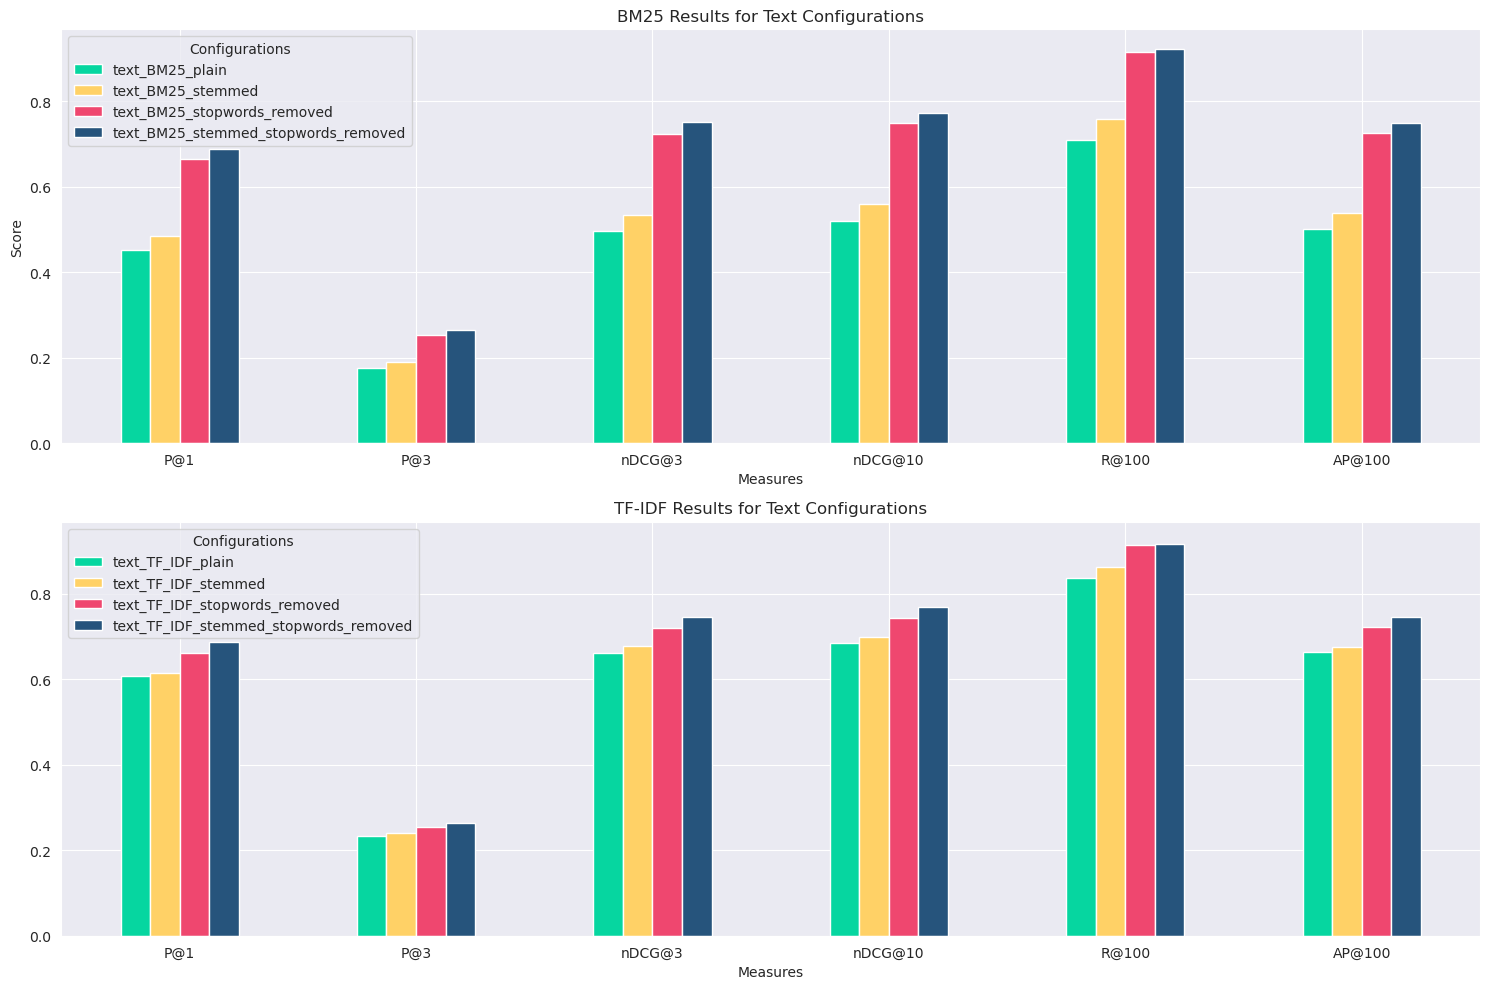

In [16]:
# Filter the results for text_BM25 and text_TF_IDF
results_df = results_df.drop('mrt', axis=1)
text_bm25_results = results_df.filter(like='text_BM25', axis=0)
text_tfidf_results = results_df.filter(like='text_TF_IDF', axis=0)
measures_to_plot = text_bm25_results.columns

# Plot the results
colors = ['#06d6a0', '#ffd166', '#ef476f', '#26547c']

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

# Plot BM25 results
text_bm25_results.T.plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('BM25 Results for Text Configurations')
axes[0].set_xlabel('Measures')
axes[0].set_ylabel('Score')
axes[0].set_xticks(range(len(measures_to_plot)))
axes[0].set_xticklabels(measures_to_plot, rotation=0)
axes[0].legend(title='Configurations')
axes[0].grid(True)

# Plot TF-IDF results
text_tfidf_results.T.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('TF-IDF Results for Text Configurations')
axes[1].set_xlabel('Measures')
axes[1].set_xticks(range(len(measures_to_plot)))
axes[1].set_xticklabels(measures_to_plot, rotation=0)
axes[1].legend(title='Configurations')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Applying stemming and stopwords removal gives the best performances in all the measures, for both TF-IDF and BM25

,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100
name,,,,,,
text_BM25_stemmed_stopwords_removed,0.689,0.265,0.751,0.772,0.923,0.749
text_TF_IDF_stemmed_stopwords_removed,0.687,0.263,0.747,0.770,0.917,0.747


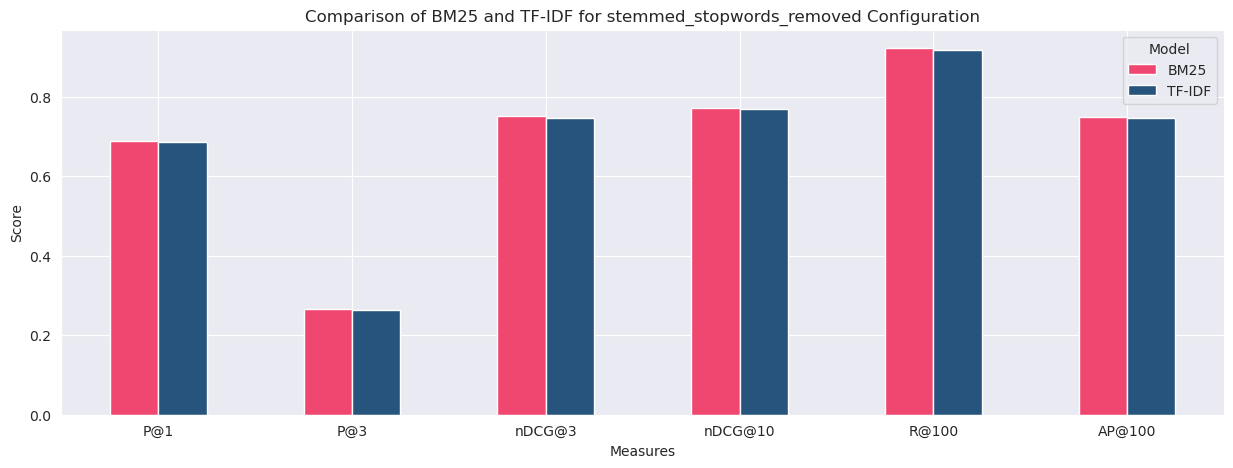

In [17]:
# Filter the results for the configuration "stemmed_stopwords_removed"
bm25_stemmed_stopwords_removed = results_df.loc['text_BM25_stemmed_stopwords_removed']
tfidf_stemmed_stopwords_removed = results_df.loc['text_TF_IDF_stemmed_stopwords_removed']

# Combine the results into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'BM25': bm25_stemmed_stopwords_removed,
    'TF-IDF': tfidf_stemmed_stopwords_removed
})

# Display the comparison
display(results_df.loc[['text_BM25_stemmed_stopwords_removed', 'text_TF_IDF_stemmed_stopwords_removed']].round(3))
# Plot the comparison
comparison_df.plot(kind='bar', figsize=(15, 5), color=['#ef476f', '#26547c'])
plt.title('Comparison of BM25 and TF-IDF for stemmed_stopwords_removed Configuration')
plt.xlabel('Measures')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True)
plt.show()

The difference between BM25 and TF-IDF with stemming and stopwords removal is minimal.

**Chosen configuration** = *'text_BM25_stemmed_stopwords_removed'*

# Tuning BM25

Now we can try to tune the weighting parameters of BM25 which are *c* (b) and *k_1*

In [24]:
# take a subset of the test set for the training
train_sub_bestConifg = train_sub_configs['text'][['qid', 'stemmed_stopwords_removed']]
train_sub_bestConifg.columns = ['qid', 'query']

# get the best config found before
index = indexes['stemmed_stopwords_removed']
BM25 = pt.terrier.Retriever(index, wmodel="BM25", controls={"c" : 0.75, "bm25.k_1" : 0.75}, properties={"termpipelines": ""})

# param grid
param_grid = {BM25 : {"c" : [0.6, 0.7, 0.8, 0.9, 1,0], 
                      "bm25.k_1" : [0.75, 1.2, 2, 2.5, 3]}}

# evaluation metrics
metrics = ['P.1', 'P.3', nDCG@3, nDCG@10, MAP@100, 'recall']

# optimize for P@1
gridScan_res = pt.GridScan(
    BM25,
    param_grid,
    train_sub_bestConifg,
    train_sub_qrels,
    metrics,
    jobs=10
)

Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggered by parallel_init) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
Java started (triggere

In [26]:
# save into csv file
path = "./experiments/baseline/results_gridscan.csv"
gridScan_res.to_csv(path, index=True)

columns_to_remove = ['tran_0', 'tran_1', 'R@5', 'R@10', 'R@15', 'R@20', 'R@30', 'R@200', 'R@500', 'R@1000']
display_styled(gridScan_res.drop(columns=columns_to_remove), ignore_cols=['tran_0_c', 'tran_1_bm25.k_1'])

,tran_0_c,tran_1_bm25.k_1,P.1,P.3,nDCG@3,nDCG@10,AP@100,R@100
0,0.600,0.750,0.655,0.253,0.717,0.743,0.719,0.909
1,0.600,1.200,0.664,0.257,0.727,0.752,0.727,0.913
2,0.600,2.000,0.667,0.256,0.727,0.753,0.729,0.920
3,0.600,2.500,0.659,0.255,0.722,0.750,0.725,0.920
4,0.600,3.000,0.656,0.255,0.721,0.748,0.722,0.920
5,0.700,0.750,0.669,0.257,0.730,0.756,0.732,0.914
6,0.700,1.200,0.685,0.263,0.747,0.769,0.745,0.918
7,0.700,2.000,0.684,0.262,0.746,0.769,0.745,0.925
8,0.700,2.500,0.681,0.262,0.743,0.767,0.742,0.925
9,0.700,3.000,0.675,0.261,0.739,0.763,0.738,0.925


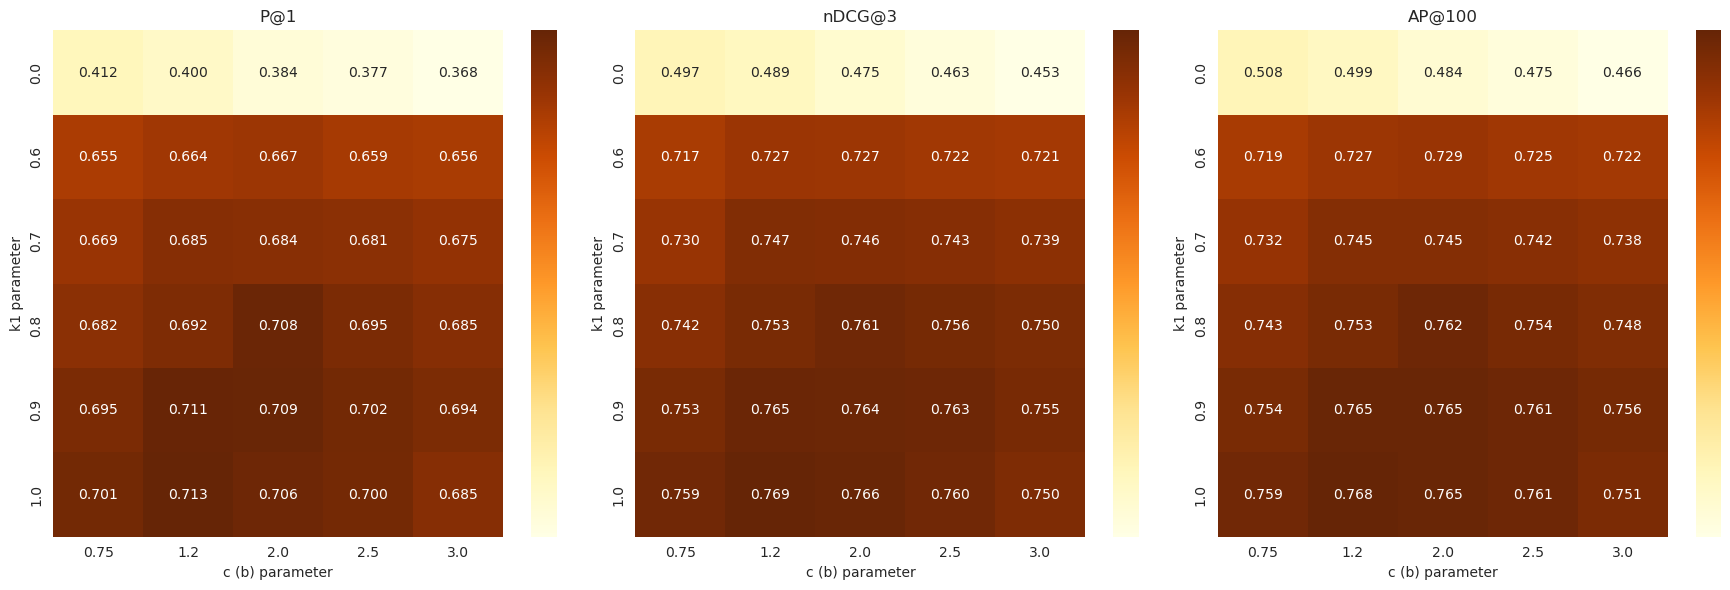

Best parameters for P@1: {'c': 1.0, 'bm25.k_1': 1.2}


In [27]:
# Plot the heatmap for P@1
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
heatmap_data_p1 = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='P.1')
sns.heatmap(heatmap_data_p1, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("P@1")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

# Plot the heatmap for nDCG@3
heatmap_data_ndcg = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='nDCG@3')
plt.subplot(1, 3, 2)
sns.heatmap(heatmap_data_ndcg, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("nDCG@3")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

# Plot the heatmap for AP@100
heatmap_data_ap = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='AP@100')
plt.subplot(1, 3, 3)
sns.heatmap(heatmap_data_ap, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("AP@100")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

plt.tight_layout()
plt.show()

best_params_p1 = gridScan_res.loc[gridScan_res['P.1'].idxmax()]
best_control_params = {'c': best_params_p1['tran_0_c'], 'bm25.k_1': best_params_p1['tran_1_bm25.k_1']}
print(f"Best parameters for P@1: {best_control_params}")

We take also a closer look to the results for the Recall@K, for different values of K

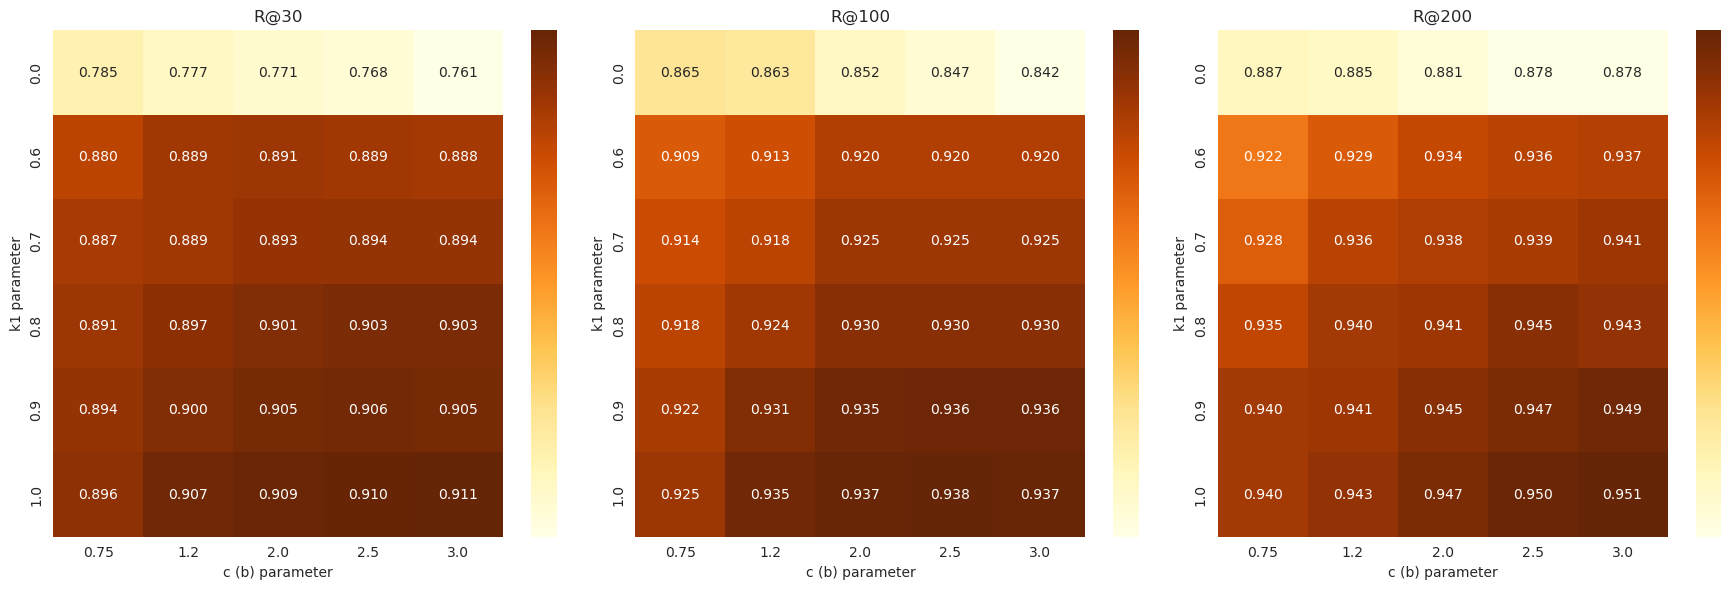

Best parameters for R@15  : {'c': 1.0, 'bm25.k_1': 2.5}
Best parameters for R@20  : {'c': 1.0, 'bm25.k_1': 2.0}
Best parameters for R@30  : {'c': 1.0, 'bm25.k_1': 3.0}
Best parameters for R@100 : {'c': 1.0, 'bm25.k_1': 2.5}
Best parameters for R@200 : {'c': 1.0, 'bm25.k_1': 3.0}
Best parameters for R@500 : {'c': 1.0, 'bm25.k_1': 3.0}

Results for best Recall parameters:


,c,k1,R@15,R@20,R@30,R@100,R@200,R@500
23,1.000,2.500,0.893,0.901,0.910,0.938,0.950,0.964
22,1.000,2.000,0.888,0.901,0.909,0.937,0.947,0.963
24,1.000,3.000,0.890,0.901,0.911,0.937,0.951,0.965


In [29]:
# Plot the heatmap for R@100
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
heatmap_data_r5 = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='R@30')
sns.heatmap(heatmap_data_r5, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("R@30")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

# Plot the heatmap for R@10
heatmap_data_r10 = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='R@100')
plt.subplot(1, 3, 2)
sns.heatmap(heatmap_data_r10, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("R@100")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

# Plot the heatmap for R@100
heatmap_data_r100 = gridScan_res.pivot(index='tran_0_c', columns='tran_1_bm25.k_1', values='R@200')
plt.subplot(1, 3, 3)
sns.heatmap(heatmap_data_r100, annot=True, cmap="YlOrBr", fmt=".3f", cbar_kws={'ticks': []})
plt.title("R@200")
plt.xlabel("c (b) parameter")
plt.ylabel("k1 parameter")

plt.tight_layout()
plt.show()

recall_data = gridScan_res[['R@15', 'R@20', 'R@30', 'R@100', 'R@200', 'R@500']]

best_configs_recall = recall_data.idxmax()
best_params = []

for col, row_idx in best_configs_recall.items():
    params = gridScan_res.loc[row_idx]
    params = {'c': params['tran_0_c'], 'bm25.k_1': params['tran_1_bm25.k_1']}
    if params not in best_params:
        best_params.append(params)
    print(f"Best parameters for {col:<5} : {params}")

rows = []
for params in best_params:
    row = gridScan_res.loc[(gridScan_res['tran_0_c'] == params['c']) & (gridScan_res['tran_1_bm25.k_1'] == params['bm25.k_1'])]
    rows.append(row)

best_params_df = pd.concat(rows)
best_params_df = best_params_df[['tran_0_c', 'tran_1_bm25.k_1', 'R@15', 'R@20', 'R@30', 'R@100', 'R@200', 'R@500']]
best_params_df = best_params_df.rename(columns={'tran_0_c': 'c', 'tran_1_bm25.k_1': 'k1'})
print("\nResults for best Recall parameters:")
display_styled(best_params_df, ignore_cols=['c', 'k1'])

Analizying the recall at different ranks k is useful for deciding the configuration of a first stage retriever in a re-ranking pipeline. we can see that the difference between R@30 and R@100 is not very high, so it could make sense to re-rank only the top 30 results instead of the top 100. this would decrease of the 70% the number of results to rerank with the neural model.

### Results on val

Now we see the results for the best configuration on the val set

- **best config** for P@1: *'text_BM25_stemmed_stopwords_removed'* with `{'c': 1.0, 'bm25.k_1': 1.2}`

- **best config** for Recall: *'text_BM25_stemmed_stopwords_removed'* with `{'c': 1.0, 'bm25.k_1': 2.5}` (we will use this in the next notebook)

In [22]:
# preprocess val queries (stemmed_stopwords_removed)
val_preprocessed = get_all_queries(val_queries, use_full_text=True)
val_preprocessed = val_preprocessed[['qid', 'stemmed_stopwords_removed']]
val_preprocessed.columns = ['qid', 'query']

# get the best config found before
index = indexes['stemmed_stopwords_removed']
best_control_params = {'c': 1.0, 'bm25.k_1': 1.2}
BM25 = pt.terrier.Retriever(index, wmodel="BM25", controls=best_control_params, properties={"termpipelines": ""})

eval_metrics = [P@1, P@3, nDCG@3, nDCG@10, R@100, MAP@100, 'mrt']

save_dir = "./experiments/baseline/"

# Run the experiment on the test set
val_results = pt.Experiment(
    [BM25],
    val_preprocessed,
    val_qrels,
    eval_metrics=eval_metrics,
    names=['val_BM25_best_params'],
    save_dir=save_dir,
    save_mode='overwrite' # 'reuse', default='warn'
)

# save into csv file
val_results_path = "./experiments/baseline/results_val.csv"
if not os.path.exists(val_results_path):
    val_results.to_csv(val_results_path, index=True)
val_results = val_results.set_index('name')
display(val_results.round(3))

,P@1,P@3,nDCG@3,nDCG@10,R@100,AP@100,mrt
name,,,,,,,
val_BM25_best_params,0.765,0.282,0.815,0.845,0.959,0.819,13.974


just with BM25 we get that 76% of the times the correct answer is ranked at the top position (in the val set).